In [ ]:

import os
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

# Create .kaggle directory if it doesn't exist
kaggle_dir = "/root/.kaggle"
os.makedirs(kaggle_dir, exist_ok=True)

# Move kaggle.json to the directory
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
with open("kaggle.json", "rb") as src:
    with open(kaggle_json_path, "wb") as dst:
        dst.write(src.read())

# Set permissions
os.chmod(kaggle_json_path, 0o600)

print("✅ kaggle.json uploaded, moved, and permissions set.")



Saving kaggle.json to kaggle.json
✅ kaggle.json uploaded, moved, and permissions set.


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kushagra3204/wheat-plant-diseases")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/wheat-plant-diseases


In [ ]:
import shutil
import os

# Source path (where kagglehub downloaded the dataset)
source_path = "/kaggle/input/wheat-plant-diseases"

# Destination path (more accessible in Colab)
destination_path = "/content/wheat_dataset"

# Copy the dataset folder
shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

print("Dataset copied to:", destination_path)
print("Files:", os.listdir(destination_path))

Dataset copied to: /content/wheat_dataset
Files: ['data']


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import kagglehub

In [ ]:
dataset_path = "/content/wheat_dataset/data"
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'validation')
test_dir = os.path.join(dataset_path, 'test')

# Check if directories exist, if not, explore structure
for dir_name, dir_path in [("Train", train_dir), ("Validation", val_dir), ("Test", test_dir)]:
    if os.path.exists(dir_path):
        print(f"{dir_name} directory found: {dir_path}")
        print(f"Classes in {dir_name}:", os.listdir(dir_path))
    else:
        print(f"{dir_name} directory not found at: {dir_path}")

# If structure is different, list all subdirectories
print("\nAll subdirectories:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")

Train directory found: /content/wheat_dataset/data/train
Classes in Train: ['Black Rust', 'Tan spot', 'Fusarium Head Blight', 'Mildew', 'Mite', 'Healthy', 'Common Root Rot', 'Stem fly', 'Leaf Blight', 'Brown Rust', 'Aphid', 'Yellow Rust', 'Blast', 'Septoria', 'Smut']
Validation directory not found at: /content/wheat_dataset/data/validation
Test directory found: /content/wheat_dataset/data/test
Classes in Test: ['leaf_blight_test', 'tan_spot_test', 'black_rust_test', 'septoria_test', 'smut_test', 'stem_fly_test', 'blast_test', 'mite_test', 'brown_rust_test', 'mildew_test', 'healthy_test', 'fusarium_head_blight_test', 'common_root_rot_test', 'aphid_test', 'yellow_rust_test']

All subdirectories:
data/
  test/
    leaf_blight_test/
    tan_spot_test/
    black_rust_test/
    septoria_test/
    smut_test/
    stem_fly_test/
    blast_test/
    mite_test/
    brown_rust_test/
    mildew_test/
    healthy_test/
    fusarium_head_blight_test/
    common_root_rot_test/
    aphid_test/
    yell

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Data generators created successfully!")

Data generators created successfully!


In [ ]:
print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load validation data
print("Loading validation data...")
val_dir = os.path.join(dataset_path, 'valid') # Corrected directory name
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load test data
print("Loading test data...")
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get dataset info
num_classes = train_generator.num_classes
class_names = list(train_generator.class_indices.keys())
print(f"\nDataset Info:")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Loading training data...
Found 13104 images belonging to 15 classes.
Loading validation data...
Found 300 images belonging to 15 classes.
Loading test data...
Found 750 images belonging to 15 classes.

Dataset Info:
Number of classes: 15
Class names: ['Aphid', 'Black Rust', 'Blast', 'Brown Rust', 'Common Root Rot', 'Fusarium Head Blight', 'Healthy', 'Leaf Blight', 'Mildew', 'Mite', 'Septoria', 'Smut', 'Stem fly', 'Tan spot', 'Yellow Rust']
Training samples: 13104
Validation samples: 300
Test samples: 750


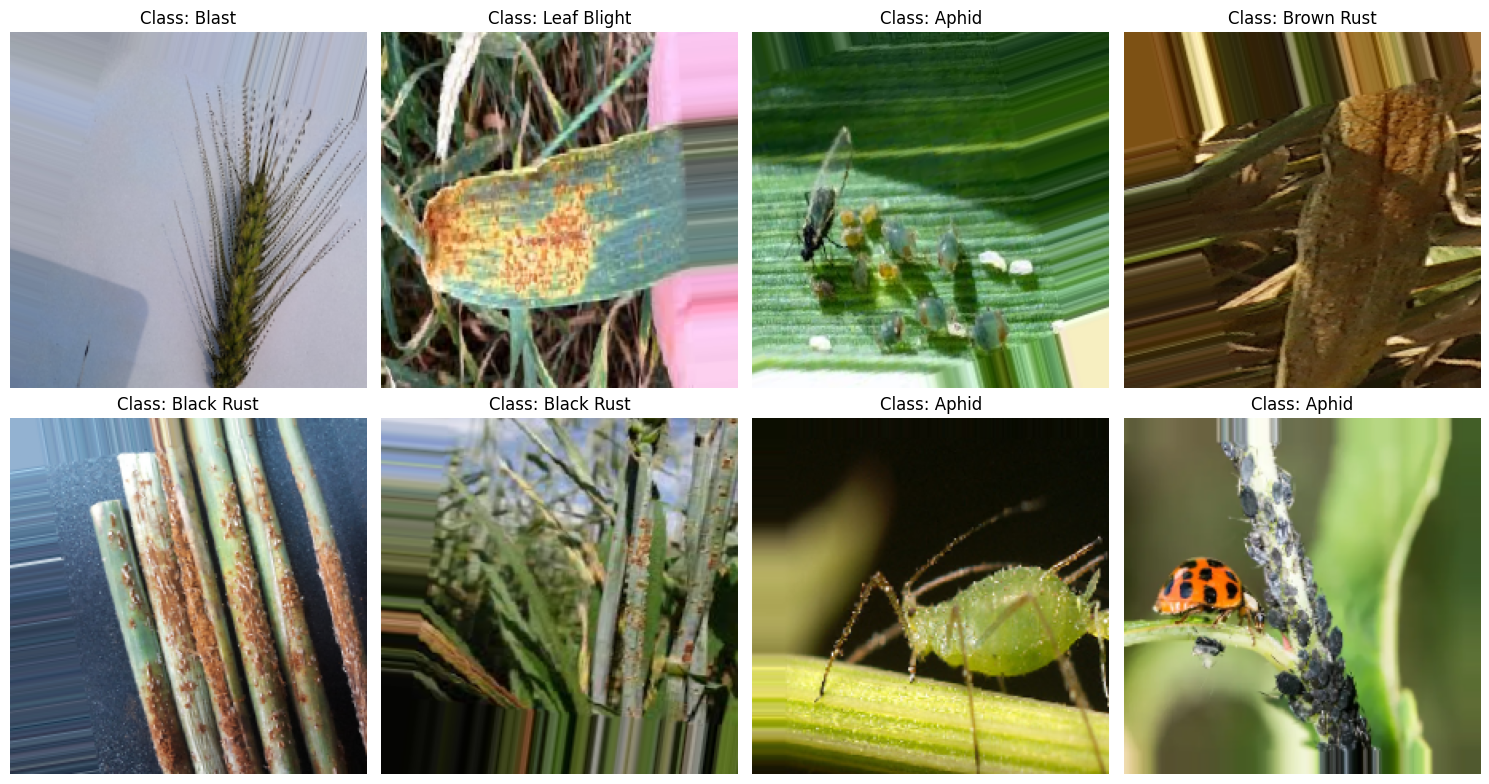

In [ ]:
def plot_sample_images(generator, class_names, num_images=8):
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    # Get a batch of images
    images, labels = next(generator)

    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i])
        class_idx = np.argmax(labels[i])
        axes[i].set_title(f'Class: {class_names[class_idx]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_sample_images(train_generator, class_names)


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 32
num_epochs = 15
learning_rate = 1e-4
image_size = 224

# Data transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = datasets.ImageFolder("/content/wheat_dataset/data/train", transform=transform)
val_dataset = datasets.ImageFolder("/content/wheat_dataset/data/valid", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)




In [ ]:
# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Modify final layer
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# Loss and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {total_loss:.4f} Train Acc: {train_acc:.2f}%")

Epoch [1/15] Loss: 348.4177 Train Acc: 72.73%
Epoch [2/15] Loss: 199.9254 Train Acc: 83.44%
Epoch [3/15] Loss: 154.7415 Train Acc: 87.33%
Epoch [4/15] Loss: 124.0023 Train Acc: 89.50%
Epoch [5/15] Loss: 107.4501 Train Acc: 90.67%
Epoch [6/15] Loss: 99.5314 Train Acc: 91.15%
Epoch [7/15] Loss: 86.7533 Train Acc: 92.29%
Epoch [8/15] Loss: 76.8233 Train Acc: 93.03%
Epoch [9/15] Loss: 66.3343 Train Acc: 93.76%
Epoch [10/15] Loss: 73.7553 Train Acc: 93.25%
Epoch [11/15] Loss: 66.7719 Train Acc: 93.64%
Epoch [12/15] Loss: 62.8724 Train Acc: 93.98%
Epoch [13/15] Loss: 55.8323 Train Acc: 94.66%
Epoch [14/15] Loss: 55.3121 Train Acc: 94.63%
Epoch [15/15] Loss: 57.7708 Train Acc: 94.40%


In [ ]:
torch.save(model.state_dict(), "resnet50_wheat_disease.pth")


In [ ]:
from google.colab import files
files.download("resnet50_wheat_disease.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>